# Diver Work

## Estructura

Areas - Fields - Features - Results (Contar este cuentito)

In [2]:
%pylab inline
### Funciones mySQL
import mysql.connector
from mysql.connector import Error
import xml.etree.ElementTree as ET
from xml.dom import minidom

## Variables globales
mySQLconnection = None
myCursor = None

def Init(verb=True):    
    global mySQLconnection, myCursor
    myHost = 'localhost'
    myDB   = 'gsr0'
    myUser = 'willy'
    myPass = 'zapandanga'
    
    try:
        mySQLconnection = mysql.connector.connect(host    =myHost,
                                                  database=myDB,
                                                  user    =myUser,
                                                  password=myPass)
        myCursor = mySQLconnection.cursor()
        if verb:
            print("Database {} connected".format(myDB))
        
    except  Error as e:
        print ("Error while connecting to MySQL", e)
        
    return None

def query(q):
    myCursor.execute(q)
    return myCursor.fetchall()

def Close(verb=True):
    if(mySQLconnection.is_connected()):
        myCursor.close()
        mySQLconnection.close()
        if verb:
            print("MySQL connection is closed")
    else:
        print("MySQL connection already closed")

def columns(table):
    cols = query("SHOW COLUMNS FROM {}".format(table))
    return list(map(lambda x:x[0],cols))

def xmlStr(xml):
    rootstr = minidom.parseString(xml).toprettyxml(indent="  ")
    rootstr = rootstr[rootstr.find('\n')+1:]
    return rootstr

def dist(x1,x2,y1,y2):
    return sqrt((x2-x1)**2+(y2-y1)**2)

Populating the interactive namespace from numpy and matplotlib


## Modificación de las tablas

### Tablas Válidas/Área principal

Sólo nos interesan las tablas que representan una medición automática de muestra. 

El mejor indicador que encontré es que existan Fields definidos en el file. 
En ese caso, el stub de trabajo será:
* el parent que tiene fields definidos
* AreaVariables.Name = 'Selected'  AreaVariables.Definition = '-1'

Como son variables de acceso incómodo, las agrego a la tabla _Files_.  
Hay 88 archivos no válidos.

El área principal es el stab de medición. Es la única que tiene fields y _ParentAreaID=0_.   
También quedó agregado a la tabla _Files_.

### Elimina `FileID` de la tabla `Ranks`, `Classes` y `Criteria`

### uMeasurements

La tabla Measurements tiene siempre los mismos elementos, pero con índices diferentes en cada file. 

Las unifico. Los uID en [1-17] están en todas las mediciones.

## Plots

In [3]:
def plotAreas(fID):
    Init(verb=False)   
    plot([25,100],[25,100],'w.')
    Date,Valid,AreaID = query('SELECT Date,Valid,AreaID from Files WHERE FileID={}'.format(fID))[0]
    Q = 'SELECT * from Areas WHERE FileID={}'.format(fID)
    v=''
    if Valid==0:
        v= 'NOT a Valid File'
    text(25,100,f'FileID: {fID}\n{Date}\n{v}',va='top',ha='left',fontsize=15)

    for ID,_,Name,Definition,DC in query(Q):
        D = ET.fromstring(Definition)

        ## Posiciones
        R = []
        for p in D[0]:
            R.append([float(p.attrib['X']),float(p.attrib['Y']),float(p.attrib['Z'])])

        ### Dibujos
        if D.attrib['Shape']=='3':
            x,y,z = zip(*R[:4])
            r = dist(x[0],x[3],y[0],y[3])
            c = [x[3],y[3]]
            if ID==AreaID:
                col = 'g'
                circle1 = Circle(c, r, color=col,Fill=True, alpha=.3)

                ### Fields
                data = query(f"SELECT X,Y,DataCollected FROM Fields WHERE (FileID={fID} AND AreaID={AreaID})")
                Width  = query(f"SELECT Definition FROM AreaVariables WHERE (FileID={fID} AND AreaID={AreaID} AND Name='FieldWidth')")
                Width  = float(Width[0][0])
                Height = query(f"SELECT Definition FROM AreaVariables WHERE (FileID={fID} AND AreaID={AreaID} AND Name='FieldHeight')")
                Height = float(Height[0][0])
                for X,Y,DC in data:
                    if DC=='1':
                        rectangle1 = Rectangle((X-Width/2,Y-Height/2), Width, Height, color='g',Fill=True, alpha=.5)
                    else:
                        rectangle1 = Rectangle((X-Width/2,Y-Height/2), Width, Height, color='g',Fill=False, alpha=.5)
                    #plot([X],[Y],'k.',markersize=1)
                    gca().add_artist(rectangle1)

            else:
                col='grey'
                circle1 = Circle(c, r, color=col,Fill=False)
            text(c[0],c[1]+r,Name, va='bottom', ha='center', color=col)
            gca().add_artist(circle1)
        else:
            #Shape=0
            shiftX = 0.7
            shiftY = 0
            if Name=='Contraste': shiftY=0.9
            if Name=='Cobalto':   shiftY=-0.9
            x,y,z = zip(*R)
            plot(x,y,'kx')
            text(x[0]+shiftX,y[0]+shiftY,Name,va='center',ha='left',alpha=0.95)

    Close(verb=False)
    axis('equal');
    

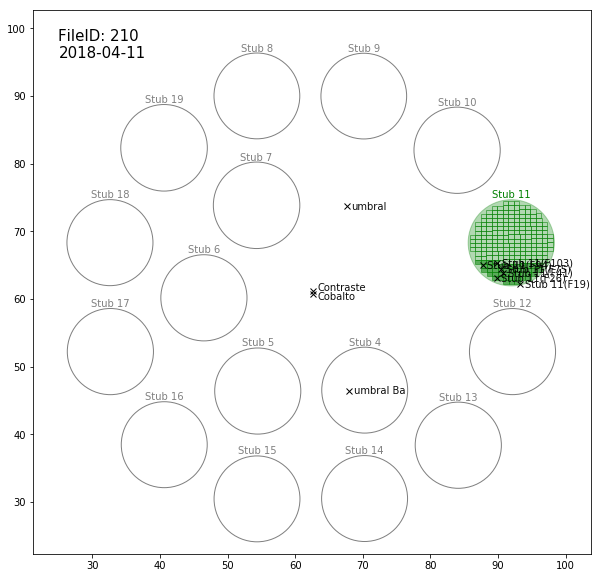

In [4]:
figure(figsize=(10,10))
plotAreas(fID=210)

In [5]:
def plotStab(fID, stat='features'):
    Init(verb=False)   
    Date,Valid,AreaID = query('SELECT Date,Valid,AreaID from Files WHERE FileID={}'.format(fID))[0]
    if Valid==0:
        print(f'FileID: {fID} is not Valid.')
        return
    # Dibujo Stub
    _,_,Name,Definition,DC = query(f"SELECT * FROM Areas WHERE FileID={fID} AND AreaID={AreaID}")[0]
    D = ET.fromstring(Definition)
    R = []
    for p in D[0]:
        R.append([float(p.attrib['X']),float(p.attrib['Y']),float(p.attrib['Z'])])
    x,y,z = zip(*R[:4])
    r = dist(x[0],x[3],y[0],y[3])
    c = [x[3],y[3]]
    
    # Plot
    col = 'g'
    circle1 = Circle(c, r, color=col,Fill=True, alpha=.3)
    gca().add_artist(circle1)
    text(c[0],c[1]+r,Name, va='bottom', ha='center', color=col, fontsize=15)
    plot([c[0]-r,c[0]+r],[c[1]-r,c[1]+r],'w.')

    # Title
    text(c[0]-r,c[1]+r,f'FileID:  {fID}\nAreaID: {AreaID}\n{Date}\nstat: {stat}',va='top',ha='left',fontsize=15)

    # Areas Puntuales
    allA = 'SELECT * from Areas WHERE FileID={}'.format(fID)
    for ID,_,Name,Definition,DC in query(allA):
        D = ET.fromstring(Definition)
        if D.attrib['Shape']=='0':
            R = []
            for p in D[0]:
                R.append([float(p.attrib['X']),float(p.attrib['Y']),float(p.attrib['Z'])])
            x,y,z = zip(*R)
            if dist(x[0],c[0],y[0],c[1])<r*1.2:
                plot(x,y,'o', label=Name[Name.find('('):], markersize=10,markeredgecolor='k',alpha=1)
                #text(x[0]+0.2,y[0],Name,va='center',ha='left',alpha=0.95)

    # Fields
    data   = query(f"SELECT FieldID,X,Y,DataCollected FROM Fields WHERE (FileID={fID} AND AreaID={AreaID})")
    Width  = query(f"SELECT Definition FROM AreaVariables WHERE (FileID={fID} AND AreaID={AreaID} AND Name='FieldWidth')")
    Width  = float(Width[0][0])
    Height = query(f"SELECT Definition FROM AreaVariables WHERE (FileID={fID} AND AreaID={AreaID} AND Name='FieldHeight')")
    Height = float(Height[0][0])
    #print('www',Width,Height)
    Nfeat  = query(f"SELECT FieldID, count(*) FROM Features WHERE FileID={fID}  GROUP BY FieldID") 
    NFid, NNF = zip(*Nfeat)
    
    for FieldID,X,Y,DC in data:
        if DC=='1':
            rectangle1 = Rectangle((X-Width/2,Y-Height/2), Width, Height, color='g',Fill=True, alpha=.5)
        else:
            rectangle1 = Rectangle((X-Width/2,Y-Height/2), Width, Height, color='g',Fill=False, alpha=.5)
        #plot([X],[Y],'k.',markersize=1)
        gca().add_artist(rectangle1)
        
        # Features
        if FieldID in NFid:
            if stat=='FieldID':
                text(X,Y,str(FieldID),va='center',ha='center',alpha=0.7,color='k')
            else: #stat=='features':
                NF = NNF[NFid.index(FieldID)] 
                text(X,Y,str(NF),va='center',ha='center',alpha=0.7,color='k')

    Close(verb=False)
    legend(loc=1)
    axis('equal');
    

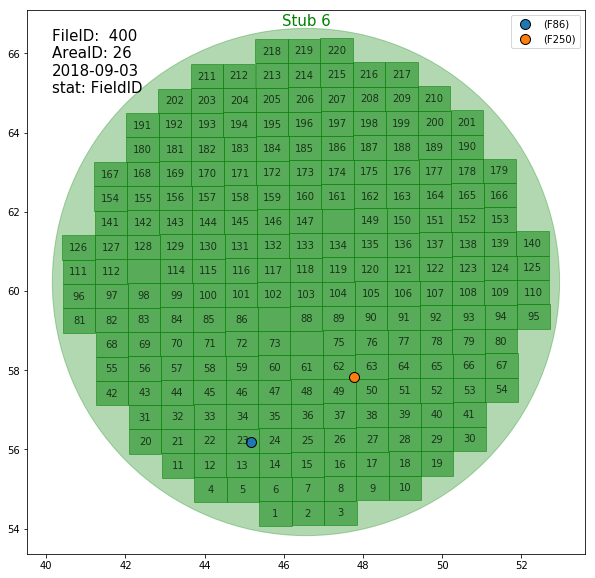

In [13]:
figure(figsize=(10,10))
plotStab(fID=400,stat='FieldID')
#savefig('figurita.png')

86 2 3
87 2 2


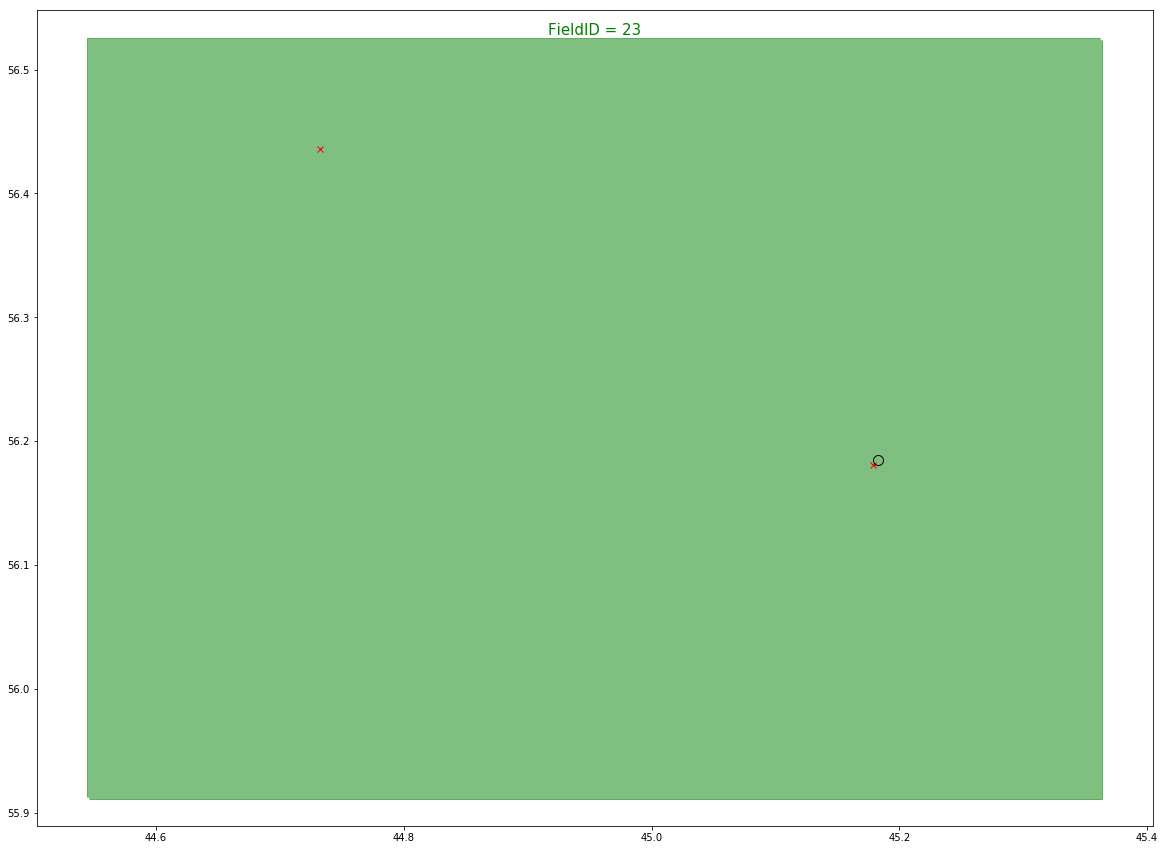

In [8]:
### Plots de Fields para chequeo
def plotField(fID,FieldID,mark=False):
    Init(verb=False)
    Valid,AreaID = query(f'SELECT Valid,AreaID from Files WHERE FileID={fID}')[0]
    if Valid==0:
        print(f'FileID: {fID} is not Valid.')
        return
    
    ### Field
    # Tamaño
    Q =  'SELECT Definition FROM AreaVariables '
    W = f'WHERE (FileID={fID} AND AreaID={AreaID} AND '
    W+=  "Name IN ('FieldWidth','FieldHeight','FieldWidthPx','FieldHeightPx'))"
    Fshape = query(Q+W)
    Fshape = list(map(lambda x: float(x[0]), Fshape))
    FW,FH,FWp,FHp = Fshape
    e = FW/FWp
    # Posición
    Q = 'SELECT X,Y,DataCollected FROM Fields '
    W =f'WHERE (FileID={fID} AND AreaID={AreaID} AND FieldID={FieldID})'
    Fpos = query(Q+W)
    FX,FY,DC = Fpos[0]
    assert DC=='1'
    # Plot
    rectangle1 = Rectangle((FX-FW/2,FY-FH/2), FW, FH, 
                           color='g',Fill=True, alpha=.5)
    gca().add_artist(rectangle1)
    plot([FX-FW/2,FX+FW/2],[FY-FH/2,FY+FH/2],'w.')
    text(FX,FY+FH/2,f'FieldID = {FieldID}', va='bottom', ha='center', color='g', fontsize=15)
    
    ### Features en ese campo, de la tabla Features
    Q =  'SELECT FeatureID,BB_Top, BB_Left, BB_Height, BB_Width, Rank FROM Features ' 
    W = f'WHERE (FileID={fID} AND FieldID={FieldID})'
    Feats = query(Q+W)
    for FeatureID,BB_Top, BB_Left, BB_Height, BB_Width, Rank in Feats: 
        print(FeatureID,BB_Height, BB_Width)
        #XX = FX-FW/2 + e * (BB_Left)
        #YY = FY+FH/2 - e * (BB_Top + BB_Height)
        XX = FX+FW/2 - e * (BB_Left)   # ?????    Está invertido derecha-Izquierda
        YY = FY-FH/2 + e * (BB_Top + BB_Height) # Está al derecho arriba-abajo  es peor, porque suma Top y Height
        if mark:
            plot(XX,YY,'rx')
        rectangle1 = Rectangle((XX,YY), e*BB_Width, e*BB_Height, 
                           color='r',Fill=True, alpha=.8)
        gca().add_artist(rectangle1)
        
    # Areas Puntuales
    allA = 'SELECT * from Areas WHERE FileID={}'.format(fID)
    for ID,_,Name,Definition,DC in query(allA):
      if f'(F86)' in Name:
        D = ET.fromstring(Definition)
        if D.attrib['Shape']=='0':
            R = []
            for p in D[0]:
                R.append([float(p.attrib['X']),float(p.attrib['Y']),float(p.attrib['Z'])])
            x,y,z = zip(*R)
            #if dist(x[0],c[0],y[0],c[1])<r*1.2:
            plot(x,y,'o', label=Name[Name.find('('):], markersize=10,markeredgecolor='k', markerfacecolor='None',alpha=1)    
    Close(verb=False)
    axis('equal')
    

figure(figsize=(20,15))
plotField(fID=400,FieldID=23,mark=True) #23 24
    

--------------------
Por trabajar:
* Areas.Definition  OriginalFeatureID
* AreaVariables  Name=NumFields Name=FieldWidthPx, FieldHeightPx
* Mediciones de referencia ? Todas la áreas dan todas las mediciones?
* Stats anunciadas en los gráficos
* Funciones  
-----------------------
Funciones sin gráficos:
* Área escaneada
* Stats sobre el área
-----------------------
Funciones de historial y metadata   
Funciones de mdb